### LARS

imports

In [30]:

import scipy.io
import numpy as np
import math
from sklearn import linear_model 
import pandas as pd
from scipy import linalg
from sklearn import preprocessing as preproc # load preprocessing function
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from sklearn.model_selection import KFold

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

In [31]:
!ls ../data/

case1Data.csv  case1Data_Xnew.csv


In [32]:
# Load the data from the CSV file                                 
data = np.genfromtxt('../data/case1Data.csv', delimiter=',', skip_header=1,    
filling_values=np.nan)                                            

y = data[:, 0]
X = data[:, 1:]

[n, p] = X.shape

#Pandas dataframe
df = pd.read_csv("../data/case1Data.csv")  # Replace with actual filename
df_new = pd.read_csv("../data/case1Data_Xnew.csv")  # Replace with actual filename

Wrangling

In [33]:

#Mode imputation for the categorical features
df.iloc[:, -5:] = df.iloc[:, -5:].apply(lambda col: col.fillna(col.mode()[0]))
df_new.iloc[:, -5:] = df_new.iloc[:, -5:].apply(lambda col: col.fillna(col.mode()[0]))

#Filling out the missing values in the numerical features with the mean
df.iloc[:, 1:-5] = df.iloc[:, 1:-5].apply(lambda col: col.fillna(col.mean()))

#One-hot encoding the categorical features
df = pd.get_dummies(df, columns=df.columns[-5:], dtype=int)

# Convert the numerical columns to float before applying standardization
df.iloc[:, :-36] = df.iloc[:, :-36].astype(float)

#MAking np arrays for data
y = df.iloc[:, 0].to_numpy()
X = df.iloc[:, 1:].to_numpy()

[n, p] = X.shape

LARS

In [34]:

betas, res, rnk, s = linalg.lstsq(X, y)
y_ols = X@betas
# Using the mean squared error (MSE) of a low bias model (OLS) as the estimate for the noise variance
s2 = np.mean((y-y_ols)**2)  
print(s2)

1.7114772789989532e-25


In [35]:

def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

def normalize(X):
    '''
    Function for normalizing the columns (variables) of a data matrix to unit length.
    Returns the normalized data and the euclidian lenghts of the variables 
    
    Input  (X) --------> The data matrix to be normalized 
    Output (X_pre)-----> The normalized data matrix 
    Output (d) --------> Array with the euclidian lenghts of the variables 
    '''
    d = np.linalg.norm(X,axis=0,ord=2)  # d is the the L2 norms of the variables
    d[d==0]=1                           # Avoid dividing by zero if column L2 norm is 0 
    X_pre = X / d                       # Normalize the data with the euclidian lengths
    return X_pre,d                      # Return normalized data and the euclidian lengths

CV = 5 # if K = n leave-one-out, you may try different numbers

kf = KFold(n_splits=CV)
stop = n-math.ceil(n/CV)
K = range(1,stop)

Err_tr = np.zeros((CV,len(K)))
Err_tst = np.zeros((CV, len(K))) 

# Lars
for i, (train_index, test_index) in enumerate(kf.split(X)):
    ytrain = y[train_index].ravel() # ravel collapses the array, ie dim(x,1) to (x,)
    ytest = y[test_index].ravel() 
    Xtrain = X[train_index]
    Xtest = X[test_index]

    # NOTE: If you normalize outside the CV loop the data implicitly carry information of the test data
    # We should perform CV "the right way" and keep test data unseen.    
    ytrain, mu = centerData(ytrain); # center training response
    ytest = ytest-mu; # use the mean value of the training response to center the test response
    
    Xtrain, mu = centerData(Xtrain); # center training data
    Xtest = Xtest-mu; # use the mean value of the training data to center the test data
    
    Xtrain,d = normalize(Xtrain) # normalize training data
    Xtest = Xtest / d # normalize test data using euclidian length of train data columns
    # compute all LARS solutions
    for nj,j in enumerate(K):
        reg = linear_model.Lars(n_nonzero_coefs=j, fit_path = False, fit_intercept = False, verbose = True)
        reg.fit(Xtrain,ytrain)
        beta = reg.coef_.ravel()
        
        # Predict with this model, and find error
        YhatTr = Xtrain @ beta
        YhatTest = Xtest @ beta
        
        Err_tr[i-1, nj] = np.mean((YhatTr-ytrain)**2) # training error
        Err_tst[i-1, nj] = np.mean((YhatTest-ytest)**2) # test error
        
err_tr = np.mean(Err_tr, axis=0) # mean training error over the CV folds
err_tst = np.mean(Err_tst, axis=0) # mean test error over the CV folds
err_ste = np.std(Err_tst, axis=0)/np.sqrt(CV) # Note: we divide with sqrt(n) to get the standard error as opposed to the standard deviation

Cp = np.zeros((len(K)))



/home/aws/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=2.879e-01, with an active set of 37 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/aws/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=2.879e-01, with an active set of 37 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/aws/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=2.879e-01, with an active set of 37 regressors, and the sma

In [40]:
# The error
print(f"Training error: {err_tr}")
print(f"Test error: {err_tst}")


Training error: [2980.30174401 2662.05969777 1779.95781691 1522.63571213 1434.1056754
 1318.79168167 1199.33150118 1099.2035345  1030.17867566  980.19321785
  946.02296971  888.57903002  848.21456357  790.73821428  768.45078844
  751.33361076  725.81973948  684.33138776  627.11996036  612.22676834
  589.31542162  577.27454955  559.30533622  544.41493986  518.45230007
  504.48289681  499.46942559  482.03436103  466.23134721  444.38017938
  424.24829122  412.59401848  404.52950531  402.20894317  395.33591472
  391.58756371  382.76752885  371.96777553  366.92906192  363.78042058
  364.16924673  364.22387073  365.86692342  364.2168206   365.07015949
  365.94521801  368.73699784  373.23954419  384.99013113  390.86663758
  404.27723304  415.882416    423.44492853  425.42762053  436.61683079
  447.82064471  455.60164904  466.32202443  478.39900614  492.55087551
  513.19549027  537.61575173  543.77135744  553.5852172   575.349606
  589.05755388  597.66816217  614.48095031  645.88580752  705.45

In [36]:

# Compute Cp-statistic, assumption n > p
X_norm,_ = centerData(X)
X_norm,_ = normalize(X_norm)

Betas = np.zeros((p, n))
for j in range(1,n):
    reg = linear_model.Lars(n_nonzero_coefs=j)
    reg.fit(X_norm,y)
    Betas[:,i] = reg.coef_

Cp = np.zeros((len(K)))
for j in range(len(K)):
    Yhat = X_norm @ Betas[:,K[j]]
    Cp[j] = np.mean(((y-Yhat)**2)) + 2*K[j]/n*s2

79


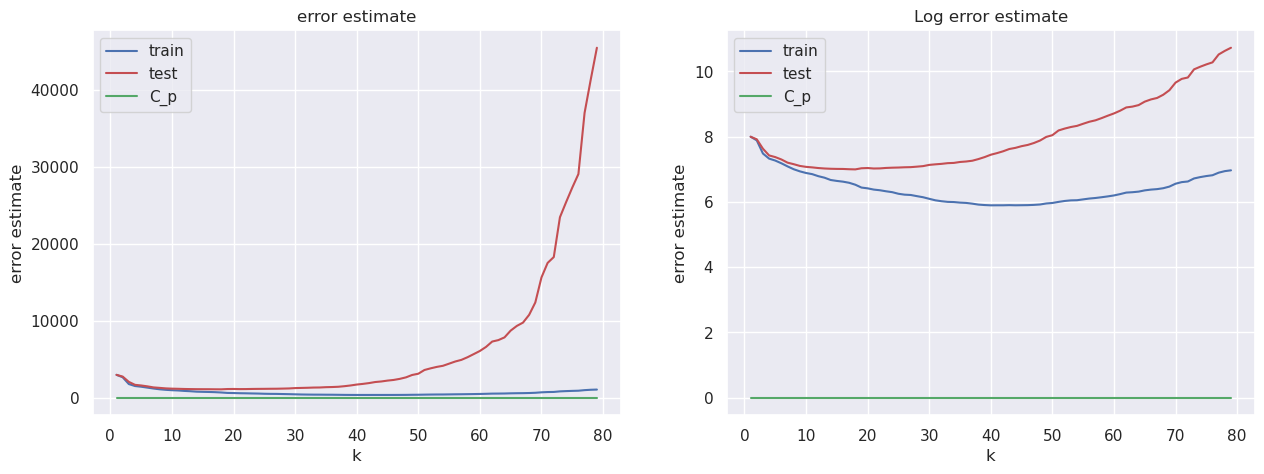

In [37]:

print(len(K))
fig, ax = plt.subplots(1,2, figsize=(15,5))    
ax[0].plot(K, err_tr, 'b', label='train')
ax[0].plot(K, err_tst, 'r', label='test')
ax[0].plot(K, Cp/1e27, 'g', label= 'C_p') # scale to put in same plot
ax[0].legend()
ax[0].set_xlabel('k')
ax[0].set_ylabel('error estimate')
ax[0].set_title("error estimate")

ax[1].plot(K, np.log(err_tr), 'b', label='train')
ax[1].plot(K, np.log(err_tst), 'r', label='test')
ax[1].plot(K, Cp/1e27, 'g', label= 'C_p') # scale to put in same plot
ax[1].legend()
ax[1].set_xlabel('k')
ax[1].set_ylabel('error estimate')
ax[1].set_title("Log error estimate")
plt.show()
# NOTE: Curves are flat, and minimum varies with split of data (running K-fold CV several times)
# We can use the "one-standard-error rule" to choose the optimal value of K and avoid these effects
